# Exploratory Spatio-Temporal Data Analysis
# Data Inspection and Descriptive Statistics - Summary Statistics

In [27]:
import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

import folium
from mpl_toolkits.basemap import Basemap

%matplotlib inline

In [43]:
import xarray as xr
import glob

def preprocess_dataset(ds: xr.Dataset) -> xr.Dataset:
    """
    Preprocess the dataset to ensure the `valid_time` coordinate is in `datetime64[ns]` format.

    Args:
        ds (xr.Dataset): Input dataset.

    Returns:
        xr.Dataset: Preprocessed dataset with `valid_time` converted to datetime.
    """
    if "valid_time" in ds.coords:
        ds["valid_time"] = ds["valid_time"].dt.floor("D")  # Truncate to date only
    return ds

# Define the directory containing your NetCDF files
data_dir = 'soil-water-forecasting/modeling-pipeline/data/01_raw/unzipped_files/ERA5_monthly_averaged_data_on_single_levels/'

# Create a sorted list of file paths
file_list = sorted(glob.glob(data_dir + '*.nc'))

# Open multiple files as a single dataset with preprocessing applied
ds = xr.open_mfdataset(
    file_list, 
    combine='by_coords', 
    preprocess=preprocess_dataset
)


In [44]:
ds

<xarray.Dataset> Size: 55GB
Dimensions:     (valid_time: 551, latitude: 721, longitude: 1440)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude    (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver      (valid_time) <U4 9kB dask.array<chunksize=(551,), meta=np.ndarray>
Data variables: (12/24)
    cl          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    cvh         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tvh         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    asn         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    sst         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    slt         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    ...          ...
    si10        (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    e           (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    ro          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    pev         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    swvl1       (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [45]:
# Update swvl1: Set to 1 wherever lsm indicates water (lsm == 1)
ds['swvl1'] = ds['swvl1'].where(ds['lsm'] != 0, other=1)

In [46]:
# Save the original attributes
original_attrs = ds['tp'].attrs

# Perform the conversion
ds['tp'] = ds['tp'] * 1000

# Restore the original attributes and update the units
ds['tp'].attrs = original_attrs
ds['tp'].attrs['units'] = 'mm'  # Update the units attribute to 'mm'

## Data Inspection

### Area of intrest

#### Snapshots 

In [48]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_variable_snapshot(
    ds: xr.Dataset,
    variable: str,
    date: str,
    figsize: tuple = (20, 12),
    cbar_label: str = 'Value',
    title: str = None,
    cmap: str = None,
    vmin: float = None,
    vmax: float = None,
    show_countries: bool = False
) -> None:
    """
    Plots a snapshot of a specified variable from an xarray Dataset for a given date using custom or specified colormaps.
    The longitude is shifted so that 0 degrees is at the center of the plot. Optionally overlays country boundaries.

    Args:
        ds (xarray.Dataset): The xarray Dataset containing the data.
        variable (str): The variable name in the dataset to plot (e.g., 'swvl1', 't2m', 'cl').
        date (str): The date for which to plot the snapshot in 'YYYY-MM-DD' format.
        figsize (tuple, optional): Size of the plot in inches. Defaults to (20, 12).
        cbar_label (str, optional): Label for the colorbar. Defaults to 'Value'.
        title (str, optional): Title of the plot. If not provided, a default title based on the variable and date will be used.
        cmap (str, optional): Colormap name to use for the plot (e.g., 'viridis', 'plasma'). 
                              If not specified, a custom colormap is used for 'swvl1', 
                              and 'viridis' is used for other variables.
        vmin (float, optional): Minimum value for color scale. Defaults to None, which uses data-specific minimum.
        vmax (float, optional): Maximum value for color scale. Defaults to None, which uses data-specific maximum.
        show_countries (bool, optional): Whether to overlay country boundaries. Defaults to False.

    Returns:
        None: Displays the plot.
    """
    # Validate if the variable exists in the dataset
    if variable not in ds.data_vars:
        raise ValueError(
            f"Variable '{variable}' not found in the dataset. "
            f"Available variables are: {list(ds.data_vars.keys())}"
        )

    # Define custom boundaries and colors for specific variables
    if variable == 'swvl1' and cmap is None:
        boundaries = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]  # Meaningful soil moisture ranges
        colors = ['red', 'orange', 'green', 'green', 'lightblue', 'blue']  # Critical to excessive moisture
        cmap_obj = mcolors.ListedColormap(colors)
        norm = mcolors.BoundaryNorm(boundaries, cmap_obj.N)
    else:
        # Use specified colormap or default 'viridis' for other variables
        cmap_name = cmap if cmap is not None else 'viridis'
        cmap_obj = plt.get_cmap(cmap_name)

        # Use provided vmin and vmax or fall back to dataset-specific min and max
        if vmin is None:
            vmin = ds[variable].min().item()
        if vmax is None:
            vmax = ds[variable].max().item()
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Select the data slice for the specified variable and date
    try:
        data_snapshot = ds[variable].sel(valid_time=date)
    except KeyError as e:
        raise KeyError(
            f"Date '{date}' not found in 'valid_time' coordinate."
        ) from e

    # Shift longitude from [0, 360) to [-180, 180)
    data_snapshot = data_snapshot.assign_coords(
        longitude=(((data_snapshot.longitude + 180) % 360) - 180)
    ).sortby('longitude')

    # Initialize the plot with PlateCarree projection
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Plot the data with the custom or specified/default colormap and normalization
    data_snapshot.plot(
        ax=ax,
        cmap=cmap_obj,
        norm=norm,
        cbar_kwargs={'label': cbar_label},
        transform=ccrs.PlateCarree()
    )

    # Overlay country boundaries if requested
    if show_countries:
        ax.add_feature(cfeature.BORDERS, linewidth=1, edgecolor='black')  # Country borders
        ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')  # Coastlines
    
    # Set the plot title
    if title is None:
        # Attempt to use the 'long_name' attribute; fallback to variable name
        long_name = ds[variable].attrs.get('long_name', variable)
        title = f'{long_name} on {date}'
    ax.set_title(title)

    # Improve layout and display the plot
    plt.tight_layout()
    plt.show()


China 

India 

Indonesia 

Pakistan 

Nigeria

Brazil

Bangladesh 

Ethiopia 

Seasons
- Bega is the dry season from December to January.[3][4]
- Belg is a short rainy season in most parts of Ethiopia. From March to May, rainfall is highly variable and high maximum temperatures are common.[6]
- Kiremt is the rainy season when 85% to 95% of food crops are produced.[8][9] Covering from June to August,
https://en.wikipedia.org/wiki/Seasons_of_Ethiopia

Droughts:
- 2011 East Africa Drought: In 2011, the rains were late, falling in late April and May, and inadequate 

- 2020–2023 Horn of Africa Drought: During the 2020–2023 Horn of Africa drought, the 2022 rainy season was recorded as the driest in over 40 years, leading to severe water and food shortages in the region. https://en.wikipedia.org/wiki/Horn_of_Africa_drought_(2020%E2%80%932023)

#### Ethiopia

##### Total precipitation

In [49]:
# vmin = ds['tp'].min().compute().item()
# vmax = ds['tp'].max().compute().item()

# vmin, vmax

In [50]:
# plot_variable_snapshot(
#     ds=ds,
#     variable='tp',
#     date='2011-04-01',
#     cbar_label='kg m-2 s-1',
#     cmap='BrBG',
#     vmin=0.0,
#     vmax=0.035,
# )

The March-May 2022 season was notably the driest on record in the last 70 years. [OCHA](https://www.unocha.org/publications/report/ethiopia/horn-africa-drought-regional-humanitarian-overview-call-action-revised-21-september-2022?utm_source=chatgpt.com)

In [51]:
# plot_variable_snapshot(
#     ds=ds,
#     variable='tp',
#     date='2022-04-01',
#     cbar_label='kg m-2 s-1',
#     cmap='BrBG',
#     vmin=0.0,
#     vmax=0.035,
# )

In [64]:
import xarray as xr
import numpy as np
from typing import Tuple

def calculate_monthly_anomalies(
    ds: xr.Dataset, 
    variable: str, 
    date_range: Tuple[str, str]
) -> xr.Dataset:
    """
    Calculate monthly anomalies for all valid_time in the dataset, 
    based on the monthly averages (climatology) over a specific date range.

    Args:
        ds (xr.Dataset): Input xarray dataset with 'valid_time' as the time dimension.
        variable (str): Name of the variable to calculate anomalies (e.g., 'swvl1').
        date_range (Tuple[str, str]): Start and end dates as strings in 'YYYY-MM-DD' format.

    Returns:
        xr.Dataset: A new dataset containing the monthly anomalies.
    """
    # Ensure the variable exists
    if variable not in ds.variables:
        raise ValueError(f"Variable '{variable}' not found in the dataset.")
    
    # Step 1: Filter dataset for the climatology period
    start_date, end_date = date_range
    ds_clim_period = ds.sel(valid_time=slice(start_date, end_date))
    
    # Step 2: Extract the variable and calculate monthly climatology
    data_clim_period = ds_clim_period[variable]
    monthly_climatology = data_clim_period.groupby('valid_time.month').mean('valid_time')

    # Step 3: Calculate anomalies for all valid_time in the original dataset
    data_full = ds[variable]
    anomalies = data_full.groupby('valid_time.month') - monthly_climatology

    # Step 4: Add anomalies to the original dataset
    ds_anomalies = ds.copy()
    ds_anomalies[f"{variable}_anomaly"] = anomalies

    return ds_anomalies


In [65]:
# Calculate anomalies for Total Precipitation based on monthly averages (e.g., all Januaries) within the range below.
date_range = ("1979-01-01", "2019-12-31")

ds = calculate_monthly_anomalies(ds, variable='tp', date_range=date_range)

In [66]:
# vmin = ds['tp_anomaly'].min().compute().item()
# vmax = ds['tp_anomaly'].max().compute().item()

# vmin, vmax

# (-0.06214509159326553, 0.1080419272184372)

In [67]:
# plot_variable_snapshot(
#     ds=ds,
#     variable='tp_anomaly',
#     date='2011-04-01',
#     cbar_label='kg m-2 s-1',
#     cmap='RdBu',
#     vmin=-0.01,
#     vmax=0.01
# )

In [68]:
# plot_variable_snapshot(
#     ds=ds,
#     variable='tp_anomaly',
#     date='2022-08-01',
#     cbar_label='kg m-2 s-1',
#     cmap='RdBu',
#     vmin=-0.01,
#     vmax=0.01
# )

In [69]:
import xarray as xr

def apply_mask(ds, anomaly_var, mask_ds_path, date, mask_name):
    """
    Apply a mask to the specified anomaly variable in a dataset.

    Args:
        ds (xr.Dataset): Original dataset containing the anomaly variable.
        anomaly_var (str): The name of the anomaly variable in `ds`.
        mask_ds_path (str): File path to the mask dataset.
        date (str): Date to select from the mask dataset (format: YYYY-MM-DD).
        mask_name (str): Name for the output masked variable (e.g., 'corn').

    Returns:
        xr.Dataset: Updated dataset with a new variable containing the masked anomaly.
    """
    # Load the mask dataset
    mask_ds = xr.open_dataset(mask_ds_path)
    mask_ds = mask_ds.sel(time=date)

    # Step 1: Adjust longitude coordinates in the mask dataset to match the range 0..360
    mask_ds = mask_ds.assign_coords(longitude=((mask_ds.longitude + 360) % 360)).sortby("longitude")

    # Step 2: Interpolate the 'value' variable from mask_ds to match the coordinates of 'ds'
    mask_interp = mask_ds['value'].interp(
        latitude=ds.latitude,
        longitude=ds.longitude
    )

    # Step 3: Create a binary mask (1 for areas with a value greater than 0, 0 otherwise)
    binary_mask = xr.where(mask_interp > 0, 1, 0)

    # Step 4: Apply the mask to the anomaly variable
    masked_anomaly = ds[anomaly_var] * binary_mask

    # Step 5: Add the masked anomaly variable to the original dataset with the specified name
    masked_var_name = f"{anomaly_var}_{mask_name}"
    ds[masked_var_name] = masked_anomaly

    return ds


In [70]:
# Example usage
ds = apply_mask(
    ds=ds,
    anomaly_var="tp_anomaly",
    mask_ds_path="/teamspace/studios/this_studio/soil-water-forecasting/modeling-pipeline/data/01_raw/corn_spei_3.nc",
    date="2024-09-08",
    mask_name="corn"
)

In [71]:
ds

<xarray.Dataset> Size: 62GB
Dimensions:          (valid_time: 551, latitude: 721, longitude: 1440)
Coordinates:
    number           int64 8B 0
  * valid_time       (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude         (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude        (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    expver           (valid_time) <U4 9kB dask.array<chunksize=(551,), meta=np.ndarray>
    month            (valid_time) int64 4kB 1 2 3 4 5 6 7 8 ... 5 6 7 8 9 10 11
    time             datetime64[ns] 8B 2024-09-08
Data variables: (12/26)
    cl               (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    cvh              (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tvh              (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    asn              (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    sst              (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    slt              (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    ...               ...
    ro               (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tp               (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    pev              (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    swvl1            (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tp_anomaly       (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
    tp_anomaly_corn  (valid_time, latitude, longitude) float64 5GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

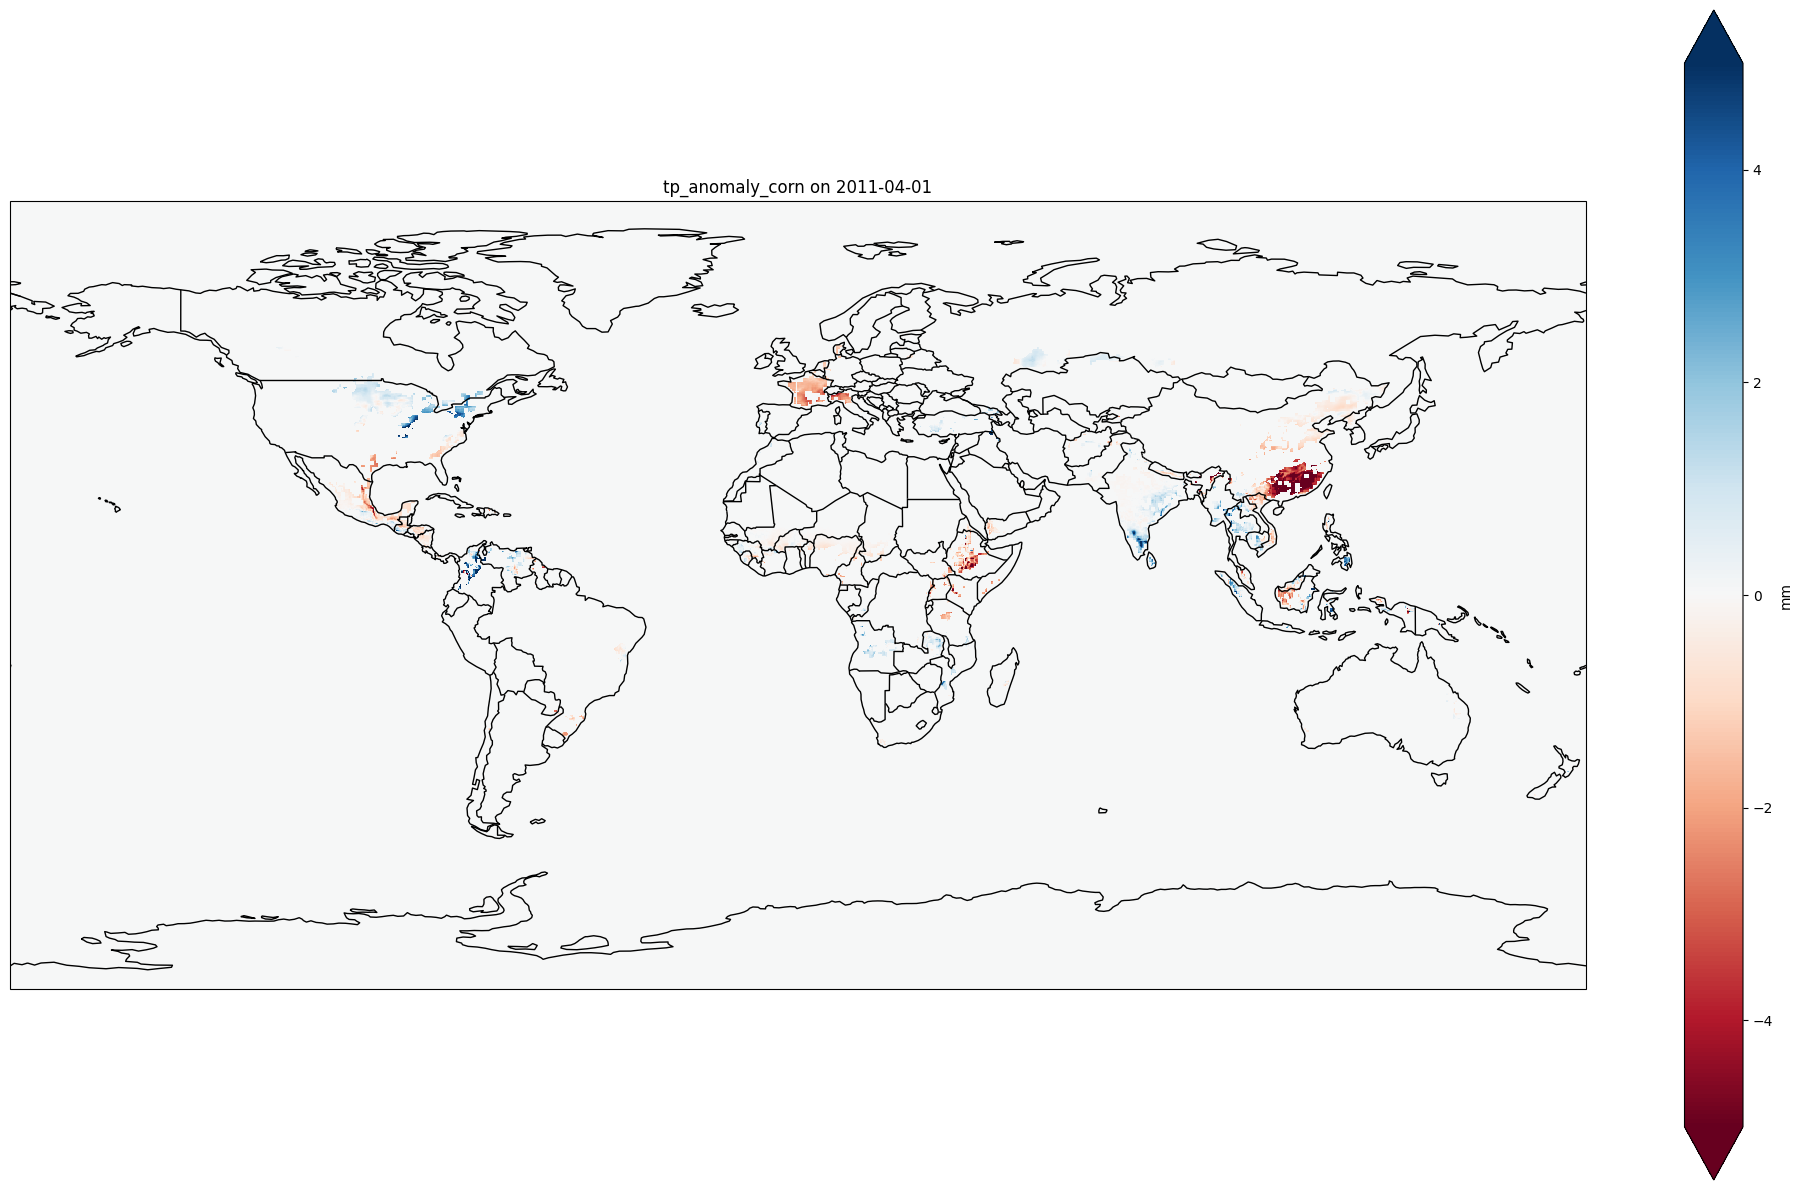

In [73]:
plot_variable_snapshot(
    ds=ds,
    variable='tp_anomaly_corn',
    date='2011-04-01',
    cbar_label='mm',
    cmap='RdBu',
    vmin=-5,
    vmax=5,
    show_countries=True
)

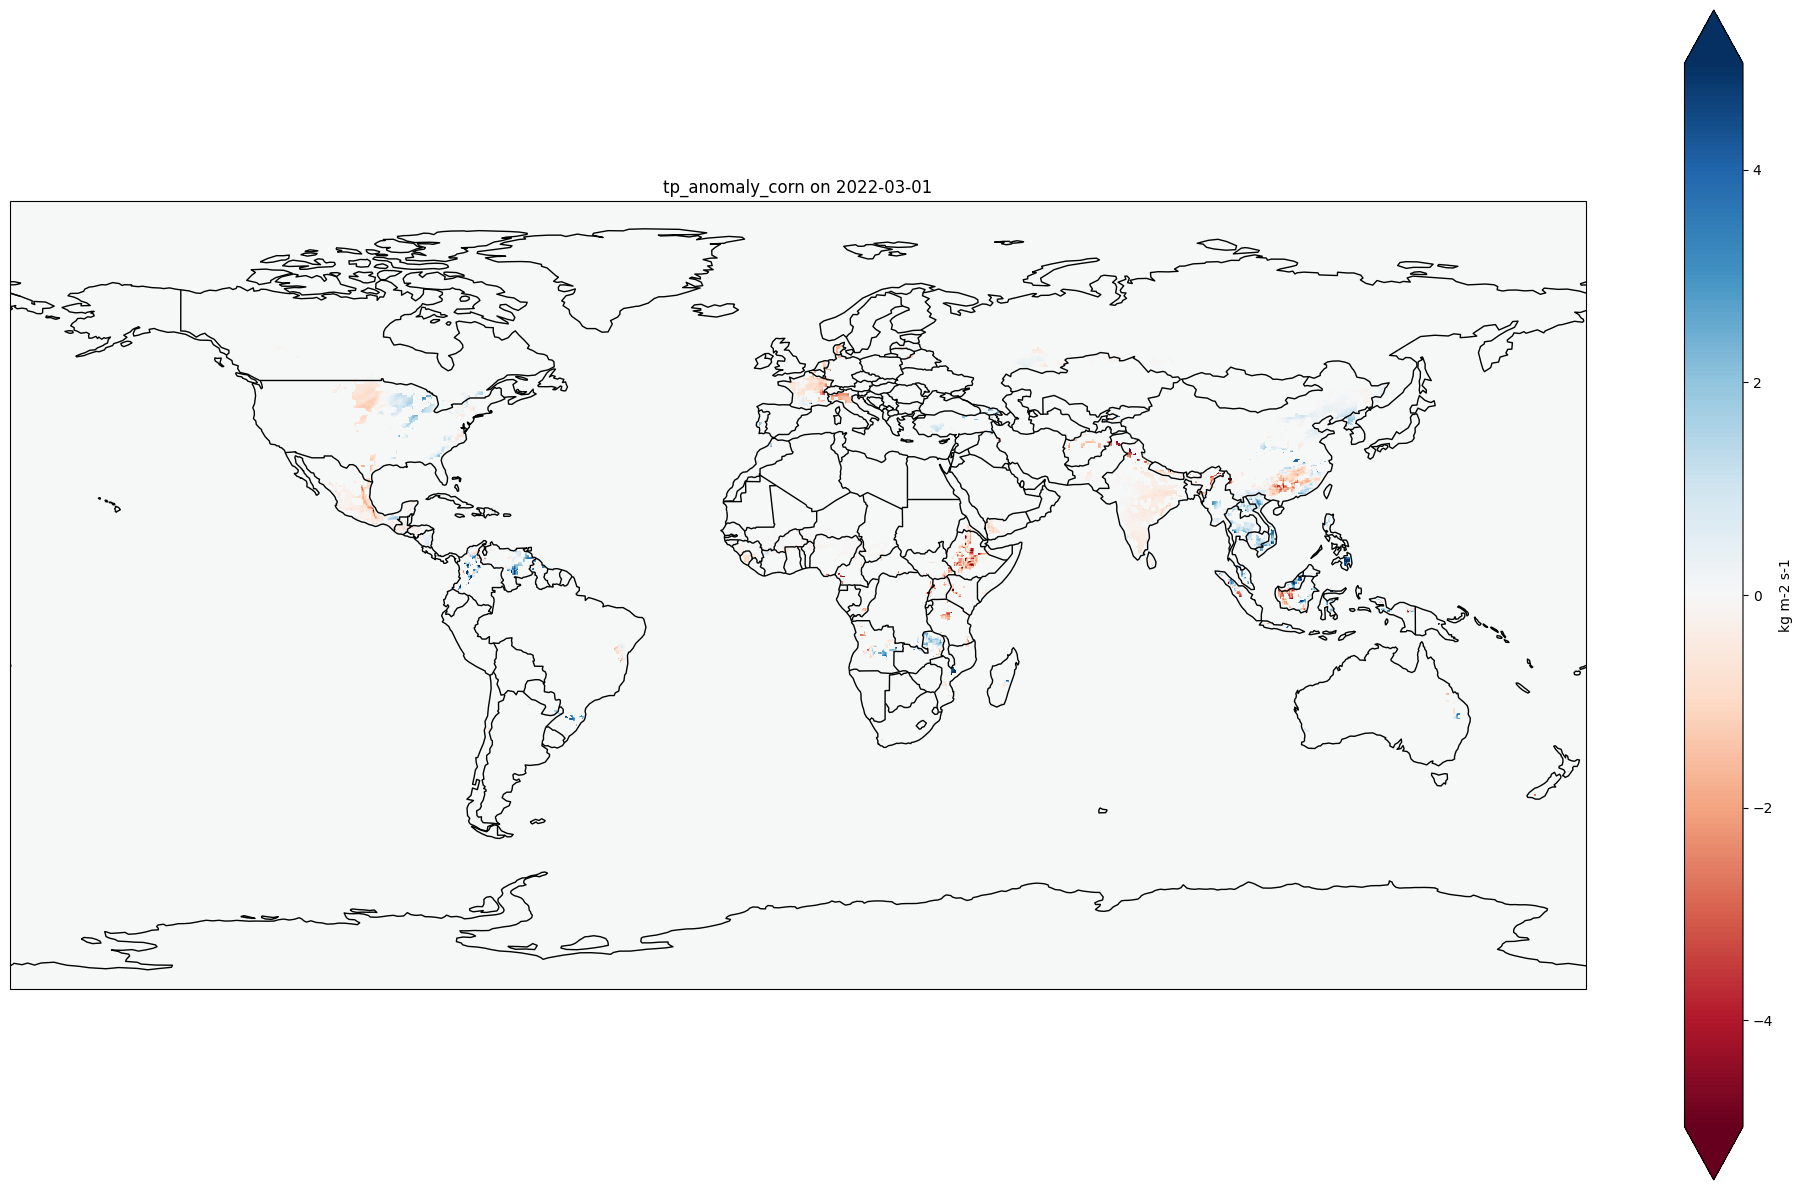

In [74]:
plot_variable_snapshot(
    ds=ds,
    variable='tp_anomaly_corn',
    date='2022-03-01',
    cbar_label='kg m-2 s-1',
    cmap='RdBu',
    vmin=-5,
    vmax=5,
    show_countries=True
)

##### Volumetric Soil Water Layer 1

In [7]:

# plot_variable_snapshot(
#     ds, 
#     variable='swvl1', 
#     date='1983-04-01', 
#     cbar_label='m3 m-3'
# )

In [9]:
# plot_variable_snapshot(
#     ds, 
#     variable='swvl1', 
#     date='2011-04-01', 
#     cbar_label='m3 m-3'
# )

In [1]:
# plot_variable_snapshot(
#     ds, 
#     variable='swvl1', 
#     date='2022-04-01', 
#     cbar_label='m3 m-3'
# )

In [11]:
# Calculate anomalies for Volumetric Soil Water Layer 1 based on monthly averages (e.g., all Januaries) within the range below.
date_range = ("1979-01-01", "2019-12-31")

ds = calculate_monthly_anomalies(ds, variable='swvl1', date_range=date_range)

In [12]:
ds

<xarray.Dataset> Size: 57GB
Dimensions:        (valid_time: 551, latitude: 721, longitude: 1440)
Coordinates:
    number         int64 8B 0
  * valid_time     (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-11-01
  * latitude       (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 12kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
    expver         (valid_time) <U4 9kB dask.array<chunksize=(551,), meta=np.ndarray>
    month          (valid_time) int64 4kB 1 2 3 4 5 6 7 8 ... 4 5 6 7 8 9 10 11
Data variables: (12/25)
    cl             (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    cvh            (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tvh            (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    asn            (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    sst            (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    slt            (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    ...             ...
    e              (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    ro             (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tp             (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    pev            (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    swvl1          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    swvl1_anomaly  (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [14]:
# plot_variable_snapshot(
#     ds=ds,
#     variable='swvl1_anomaly',
#     date='1983-04-01',
#     cbar_label='Anomaly (m³/m³)',
#     vmin=-0.2,
#     vmax=0.2,
#     cmap='RdBu'
# )

In [ ]:
# plot_variable_snapshot(
#     ds=ds,
#     variable='swvl1_anomaly',
#     date='2011-04-01',
#     cbar_label='Anomaly (m³/m³)',
#     vmin=-0.2,
#     vmax=0.2,
#     cmap='RdBu'
# )

In [ ]:
# plot_variable_snapshot(
#     ds=ds,
#     variable='swvl1_anomaly',
#     date='2022-04-01',
#     cbar_label='Anomaly (m³/m³)',
#     vmin=-0.2,
#     vmax=0.2,
#     cmap='RdBu'
# )

In [15]:


# Example usage
ds = apply_mask(
    ds=ds,
    anomaly_var="swvl1_anomaly",
    mask_ds_path="/teamspace/studios/this_studio/soil-water-forecasting/modeling-pipeline/data/01_raw/corn_spei_3.nc",
    date="2024-09-08",
    mask_name="corn"
)


In [16]:
ds

<xarray.Dataset> Size: 62GB
Dimensions:             (valid_time: 551, latitude: 721, longitude: 1440)
Coordinates:
    number              int64 8B 0
  * valid_time          (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-1...
  * latitude            (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude           (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    expver              (valid_time) <U4 9kB dask.array<chunksize=(551,), meta=np.ndarray>
    month               (valid_time) int64 4kB 1 2 3 4 5 6 7 ... 5 6 7 8 9 10 11
    time                datetime64[ns] 8B 2024-09-08
Data variables: (12/26)
    cl                  (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    cvh                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tvh                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    asn                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    sst                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    slt                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    ...                  ...
    ro                  (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tp                  (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    pev                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    swvl1               (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    swvl1_anomaly       (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
    swvl1_anomaly_corn  (valid_time, latitude, longitude) float64 5GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

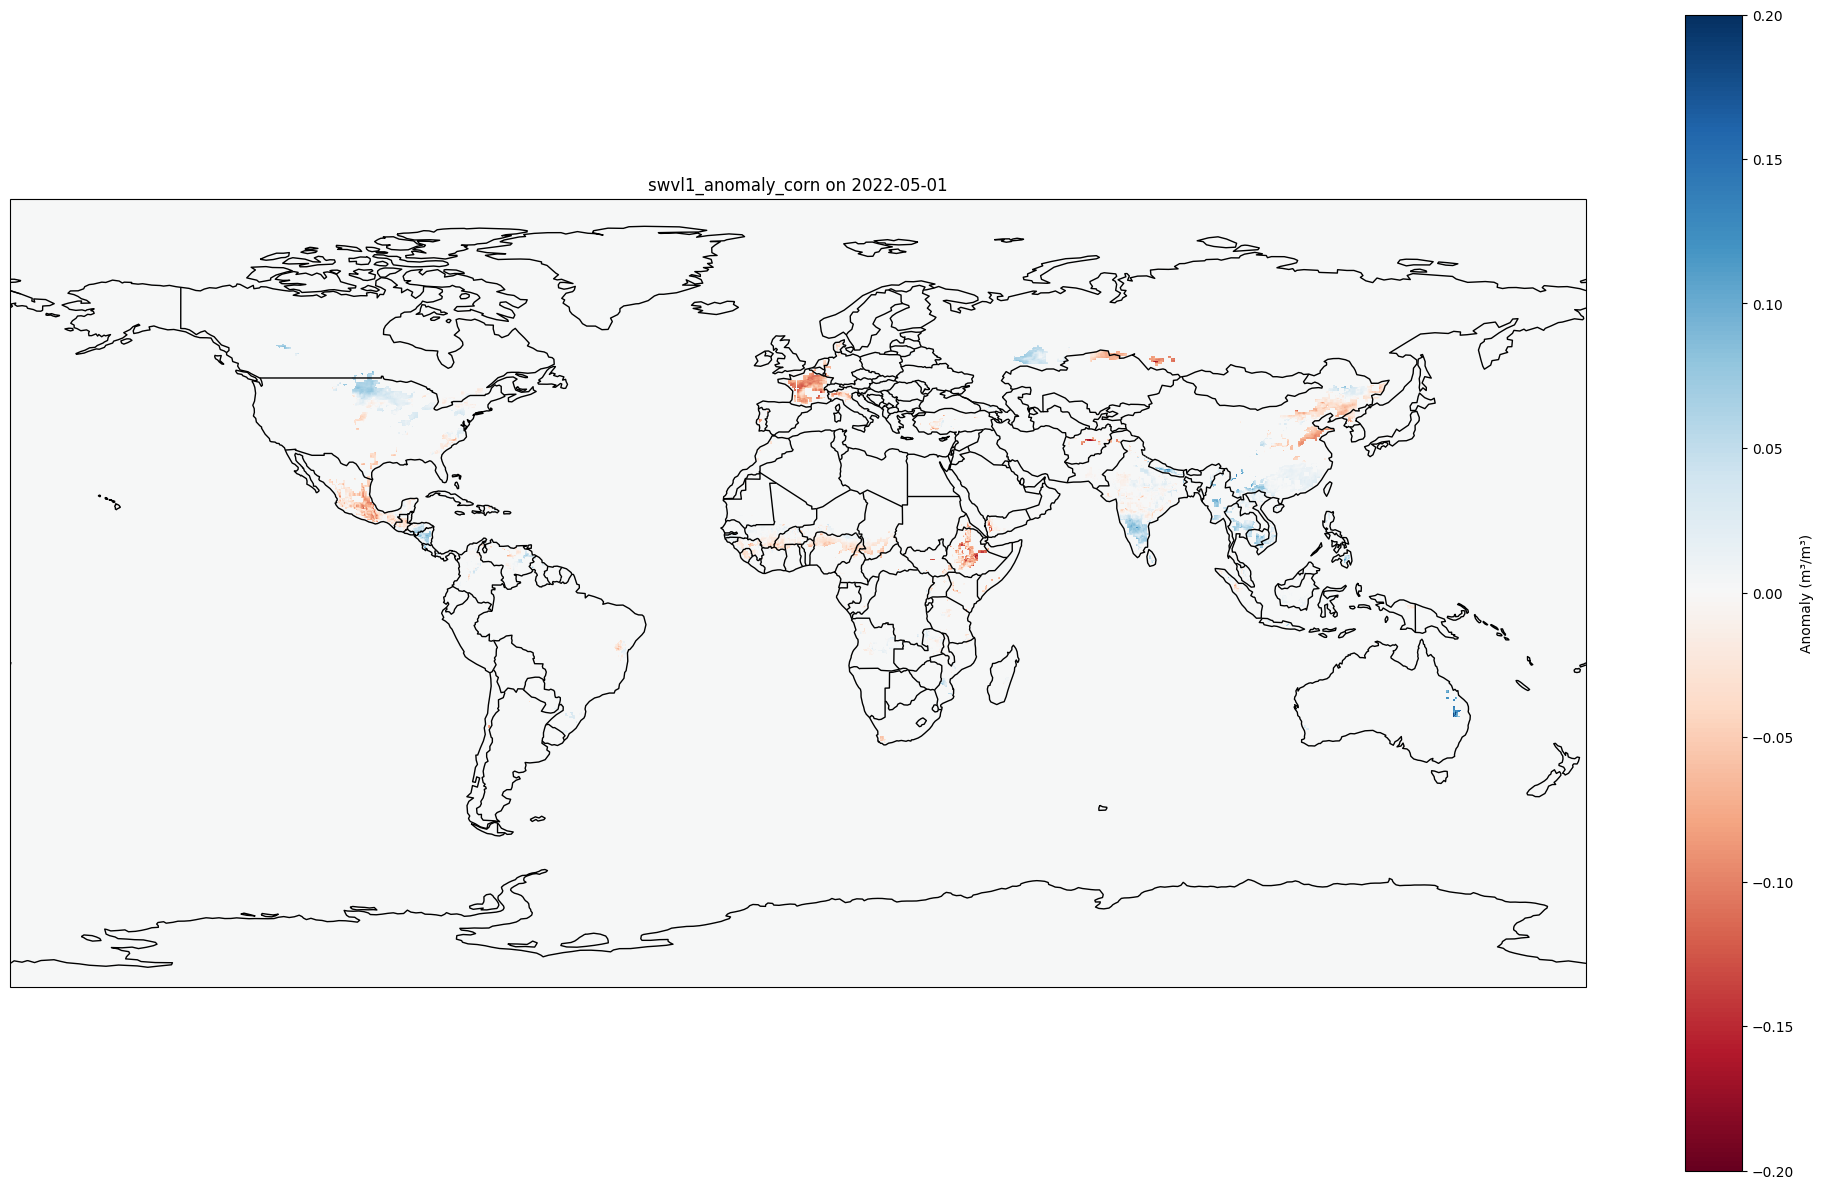

In [18]:
# Plot anomalies for a specific date
plot_variable_snapshot(
    ds=ds,
    variable='swvl1_anomaly_corn',
    date='2022-05-01',
    cbar_label='Anomaly (m³/m³)',
    vmin=-0.2,
    vmax=0.2,
    cmap='RdBu',
    show_countries=True
)

In [38]:
# vmin = ds['t2m'].min().compute().item()
# vmax = ds['t2m'].max().compute().item()

# vmin, vmax

(199.93072509765625, 316.623046875)

In [27]:
date_range = ("1979-01-01", "2019-12-31")

ds = calculate_monthly_anomalies(ds, variable='t2m', date_range=date_range)

In [28]:
ds

<xarray.Dataset> Size: 71GB
Dimensions:             (valid_time: 551, latitude: 721, longitude: 1440)
Coordinates:
    number              int64 8B 0
  * valid_time          (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-1...
  * latitude            (latitude) float64 6kB 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude           (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    expver              (valid_time) <U4 9kB dask.array<chunksize=(551,), meta=np.ndarray>
    month               (valid_time) int64 4kB 1 2 3 4 5 6 7 ... 5 6 7 8 9 10 11
    time                datetime64[ns] 8B 2024-09-08
Data variables: (12/29)
    cl                  (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    cvh                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    tvh                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    asn                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    sst                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    slt                 (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    ...                  ...
    swvl1               (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(92, 121, 240), meta=np.ndarray>
    swvl1_anomaly       (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
    tp_anomaly          (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
    tp_anomaly_corn     (valid_time, latitude, longitude) float64 5GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
    swvl1_anomaly_corn  (valid_time, latitude, longitude) float64 5GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
    t2m_anomaly         (valid_time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 121, 240), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts

In [29]:
vmin = ds['t2m_anomaly'].min().compute().item()
vmax = ds['t2m_anomaly'].max().compute().item()

vmin, vmax

(-21.022262573242188, 16.970733642578125)

In [ ]:
# Plot 't2m' (2-meter temperature) for March 15, 2023 with default 'viridis' colormap
plot_variable_snapshot(
    ds=ds,
    variable='t2m_anomaly',
    date='1997-04-01',
    cbar_label='K',
    cmap='plasma',
    vmin=199,
    vmax=315,
)

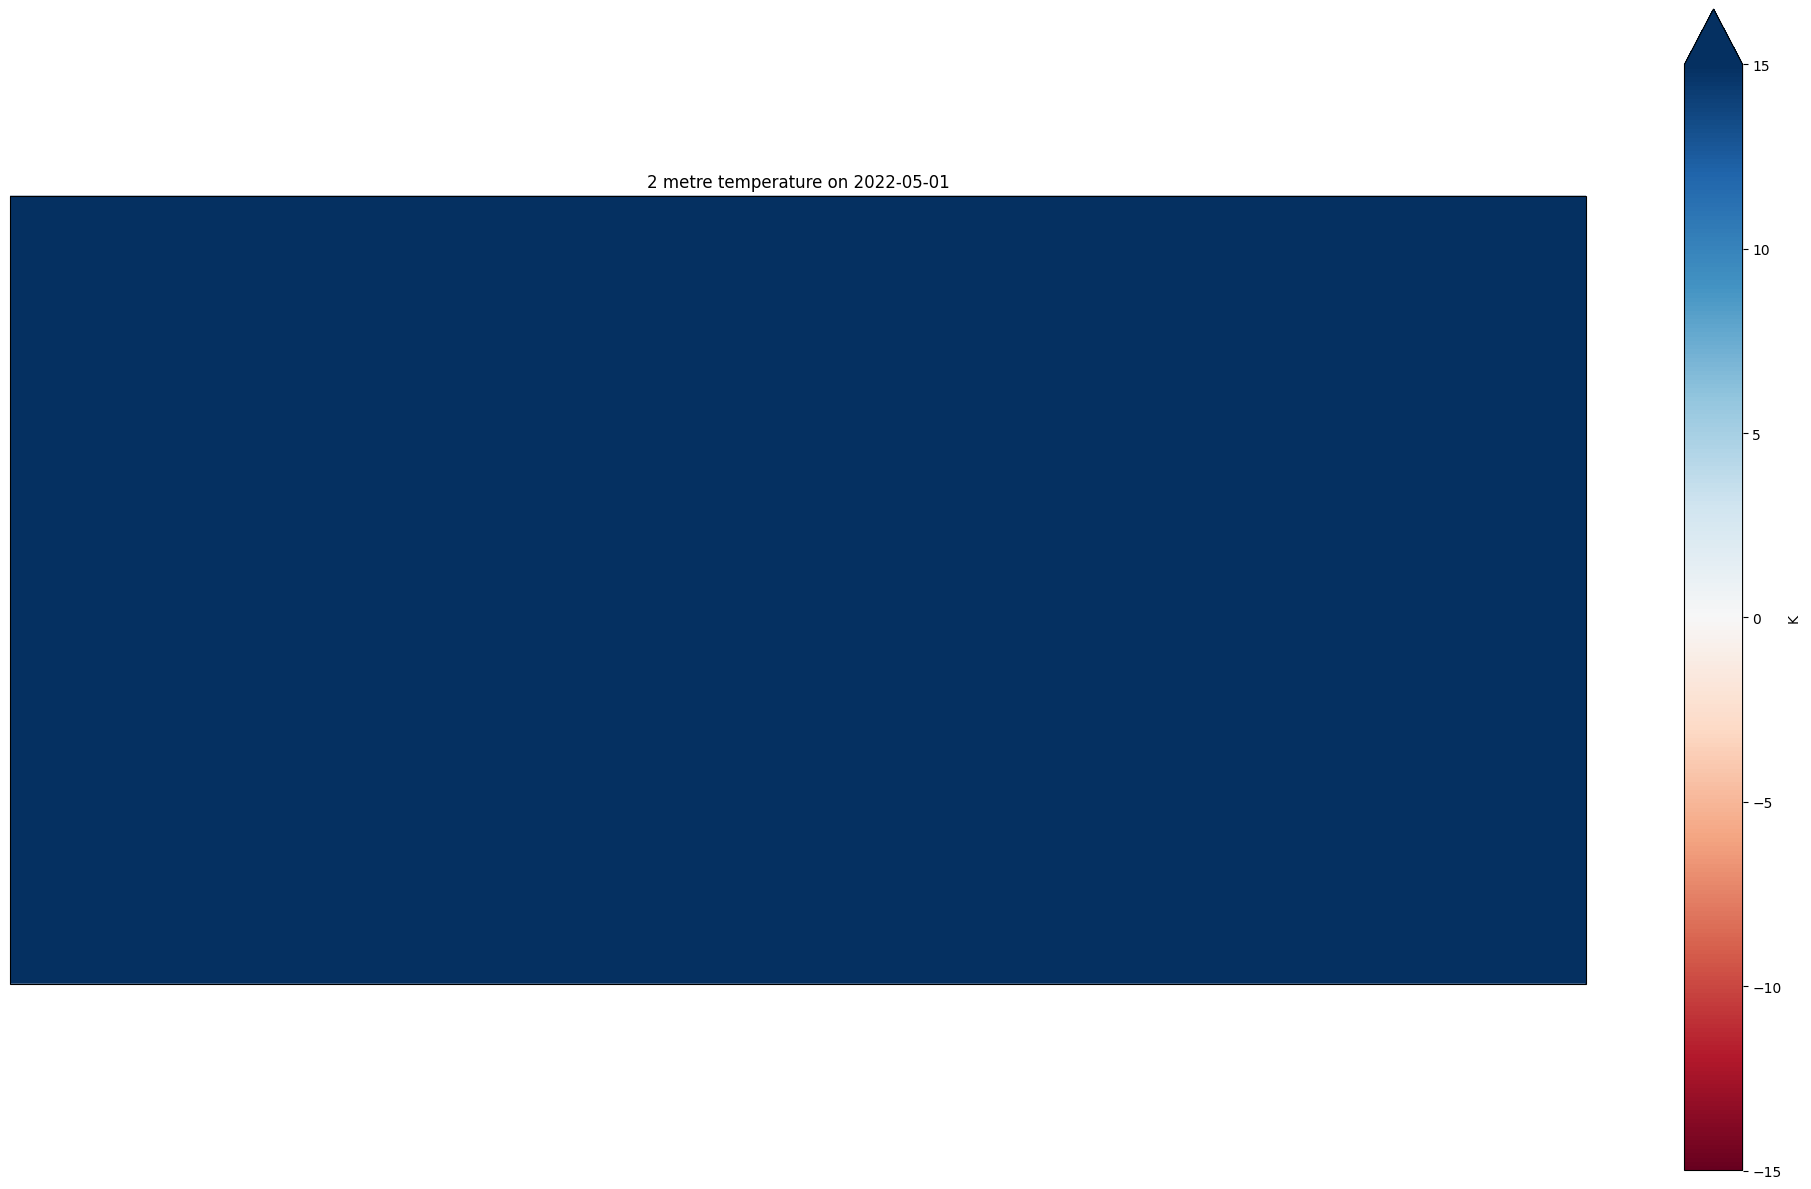

In [31]:
# Plot 't2m' (2-meter temperature) for March 15, 2023 with default 'viridis' colormap
plot_variable_snapshot(
    ds=ds,
    variable='t2m',
    date='2022-05-01',
    cbar_label='K',
    cmap='RdBu',
    vmin=-15,
    vmax=15,
)


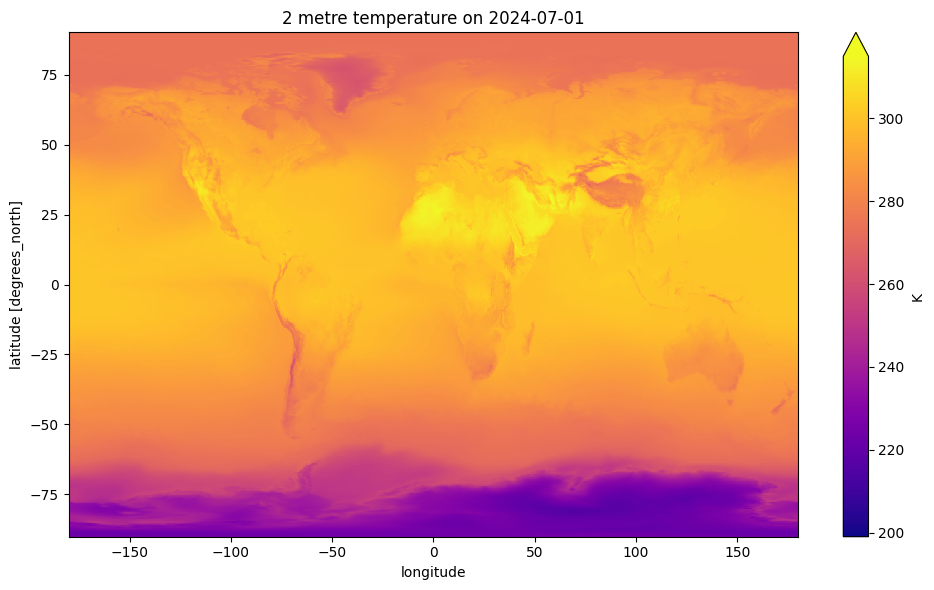

In [72]:
# Plot 't2m' (2-meter temperature) for March 15, 2023 with default 'viridis' colormap
plot_variable_snapshot(
    ds=ds,
    variable='t2m',
    date='2024-07-01',
    cbar_label='K',
    cmap='plasma',
    vmin=199,
    vmax=315,
)


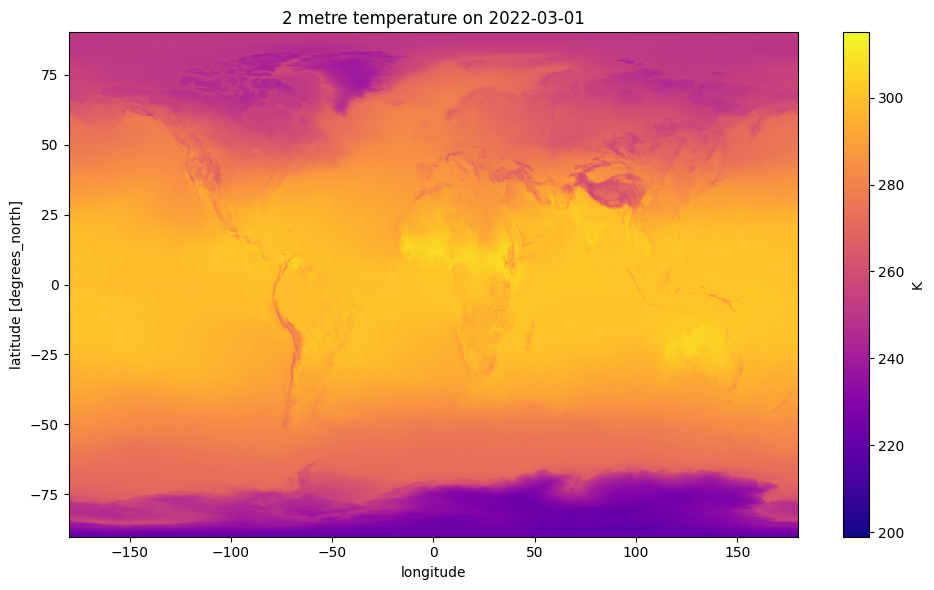

In [81]:


# Plot 't2m' (2-meter temperature) for March 15, 2023 with default 'viridis' colormap
plot_variable_snapshot(
    ds=ds,
    variable='t2m',
    date='2022-03-01',
    cbar_label='K',
    cmap='plasma',
    vmin=199,
    vmax=315,
)

#### Whole range of dates

In [9]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import xarray as xr
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from typing import Optional

def visualize_variable_on_map(
    dataset: xr.Dataset,
    variable: str,
    time_dim: str = 'valid_time',
    lat_dim: str = 'latitude',
    lon_dim: str = 'longitude',
    plot_type: str = 'scatter_geo',
    downsample_factor: Optional[int] = 1,
    projection: str = 'natural earth',
    color_scale: Optional[list] = None,
    custom_boundaries: Optional[list] = None,
    title: Optional[str] = None,
    animation_frame: Optional[str] = None,
    hover_precision: int = 2,
    custom_colorbar_title: Optional[str] = None,
    start_date: Optional[str] = None,
    end_date: Optional[str] = None,
    **kwargs
) -> go.Figure:
    """
    Function to visualize any variable from an xarray Dataset on a map with optional animation using Plotly.
    """

    # Extract GRIB metadata for title and colorbar
    grib_name = dataset[variable].attrs.get("GRIB_name", variable)
    grib_units = dataset[variable].attrs.get("GRIB_units", "")
    
    # Use GRIB_name as title if not provided
    if not title:
        title = f"{grib_name}"
        if start_date or end_date:
            title += f" ({start_date or ''} to {end_date or ''})"
    
    # Set colorbar title
    colorbar_title = custom_colorbar_title if custom_colorbar_title else grib_units

    # Extract the DataArray
    da = dataset[variable]

    # Check if variable dimensions are correct
    for dim in [time_dim, lat_dim, lon_dim]:
        if dim not in da.dims:
            raise ValueError(f"Dimension '{dim}' not found in variable '{variable}'.")

    # Filter by date range if specified
    if start_date or end_date:
        if start_date:
            da = da.sel({time_dim: da[time_dim] >= pd.to_datetime(start_date)})
        if end_date:
            da = da.sel({time_dim: da[time_dim] <= pd.to_datetime(end_date)})

    # Downsample if required
    if downsample_factor > 1:
        da = da.coarsen({lat_dim: downsample_factor, lon_dim: downsample_factor}, boundary='trim').mean()

    # Define custom boundaries and color scale if provided
    if custom_boundaries and color_scale:
        boundaries = custom_boundaries
        cmap = mcolors.ListedColormap(color_scale)
        norm = mcolors.BoundaryNorm(boundaries, cmap.N)
        color_min, color_max = boundaries[0], boundaries[-1]
    else:
        # Default min and max for the color scale
        color_min = da.min().item()
        color_max = da.max().item()

    # Plotting
    if plot_type == 'scatter_geo':
        df = da.to_dataframe().reset_index().dropna(subset=[variable])

        fig = px.scatter_geo(
            df,
            lat=lat_dim,
            lon=lon_dim,
            color=variable,
            animation_frame=animation_frame,
            projection=projection,
            color_continuous_scale=color_scale if not custom_boundaries else px.colors.make_colorscale(cmap.colors),
            title=title,
            labels={variable: grib_name},
            hover_data={variable: f":.{hover_precision}f"},
            range_color=(color_min, color_max),  # Set constant color range
            **kwargs
        )

        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )
    
    elif plot_type == 'imshow':
        z = da.mean(dim=time_dim).values  # Aggregate over time dimension for a static plot
        if da[lat_dim][0] > da[lat_dim][-1]:
            z = z[::-1, :]
        
        fig = px.imshow(
            z,
            labels=dict(x=lon_dim, y=lat_dim, color=grib_name),
            x=da[lon_dim].values,
            y=da[lat_dim].values,
            color_continuous_scale=color_scale if not custom_boundaries else px.colors.make_colorscale(cmap.colors),
            title=title,
            range_color=(color_min, color_max),  # Set constant color range
            **kwargs
        )
        
        fig.update_layout(
            coloraxis_colorbar=dict(
                title=colorbar_title,
                ticks="outside"
            )
        )
    else:
        raise ValueError(f"Plot type '{plot_type}' is not supported.")
    
    return fig

In [10]:
# # Define custom boundaries and colors
# custom_boundaries = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# custom_colors = ['red', 'orange', 'green', 'green', 'lightblue', 'blue']  # Reflect critical to excessive moisture

# # Call the function with the updated arguments
# variable = 'swvl1'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale=custom_colors,
#     custom_boundaries=custom_boundaries,
#     title='Volumetric Soil Water Layer 1'
# )

# fig.show()

In [11]:
# variable = 'u10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Bluered'
# )
# fig.show()

In [12]:
# variable = 'u10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=15,
#     color_scale = 'Bluered'
# )
# fig.show()

In [13]:
# variable = 'v10'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Bluered'
# )
# fig.show()

In [14]:
# variable = 't2m'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Thermal'
# )
# fig.show()

In [15]:
# variable = 'sst'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Plasma'
# )
# fig.show()

In [16]:
# variable = 'sp'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Plasma'
# )
# fig.show()

In [17]:
# variable = 'tp'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Blues'
# )
# fig.show()

In [18]:
# variable = 'ssr'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'YlOrBr'
# )
# fig.show()

In [19]:
# variable = 'ssrd'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'YlOrBr'
# )
# fig.show()

In [20]:
# variable = 'tcc'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'BuPu'
# )
# fig.show()

In [21]:
# variable = 'cl'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Blues'
# )
# fig.show()

In [22]:
# variable = 'e'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'YlGnBu'
# )
# fig.show()

In [23]:
# variable = 'pev'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'YlGnBu'
# )
# fig.show()

In [24]:
# variable = 'ro'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'dense'
# )
# fig.show()

In [25]:
# variable = 'asn'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'ice'
# )
# fig.show()

In [26]:
# variable = 'rsn'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'ice'
# )
# fig.show()

In [27]:
# variable = 'sd'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'ice'
# )
# fig.show()

In [28]:
# variable = 'slt'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Rainbow'
# )
# fig.show()

In [29]:
# variable = 'cvh'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'YlGn'
# )
# fig.show()

In [30]:
# variable = 'lai_hv'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'tempo'
# )
# fig.show()

In [31]:
# variable = 'tvh'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Rainbow'
# )
# fig.show()

In [32]:
# variable = 'z'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'RdBu_r'
# )
# fig.show()

In [33]:
# variable = 'lsm'

# fig = visualize_variable_on_map(
#     dataset=ds,
#     variable=variable,
#     plot_type='scatter_geo',
#     animation_frame='valid_time',
#     downsample_factor=12,
#     color_scale = 'Purpor'
# )
# fig.show()

### Missing values

In [34]:
import xarray as xr

def check_missing_percentage(dataset: xr.Dataset) -> dict:
    """
    Calculate the percentage of missing values for each variable in the xarray.Dataset.

    Args:
        dataset (xr.Dataset): The input dataset.

    Returns:
        dict: A dictionary with variable names as keys and their respective missing percentage as values.
    """
    missing_percentages = {}
    for var in dataset.data_vars:
        data = dataset[var]
        # Calculate the number of missing values and total elements
        missing_count = data.isnull().sum().item()
        total_count = data.size
        # Calculate the missing percentage
        missing_percentage = (missing_count / total_count) * 100
        missing_percentages[var] = missing_percentage
    
    return missing_percentages


In [35]:
# # Example usage
# missing_perc = check_missing_percentage(ds)

In [36]:
# missing_perc

In [18]:
# INTO 3.data_preprocessing.ipynb 

import xarray as xr
from typing import List, Union

def fillna_in_variables(
    ds: xr.Dataset,
    variables: List[str],
    fill_value: Union[int, float]
) -> xr.Dataset:
    """
    Fills NaN values in specified variables of an xarray.Dataset with a provided value.

    Args:
        ds (xr.Dataset): The input dataset containing the data variables.
        variables (List[str]): A list of variable names in the dataset for which to fill NaN values.
        fill_value (Union[int, float]): The value to fill NaN values with (e.g., 0).

    Returns:
        xr.Dataset: A new dataset with NaN values filled in the specified variables.
    
    Raises:
        ValueError: If a variable in `variables` does not exist in the dataset.
    
    Example:
        filled_ds = fillna_in_variables(ds, ["t2m", "swvl1"], fill_value=0)
    """
    # Check if each variable exists in the dataset
    for var in variables:
        if var not in ds:
            raise ValueError(f"Variable '{var}' not found in the dataset.")
    
    # Fill NaN values for the specified variables
    filled_ds = ds.copy()
    for var in variables:
        filled_ds[var] = filled_ds[var].fillna(fill_value)
    
    return filled_ds


In [19]:
ds = fillna_in_variables(ds, ["sst"], fill_value=0)

In [39]:
# # Example usage
# missing_perc_after_filling = check_missing_percentage(ds)

In [40]:
# missing_perc_after_filling

### Distributions

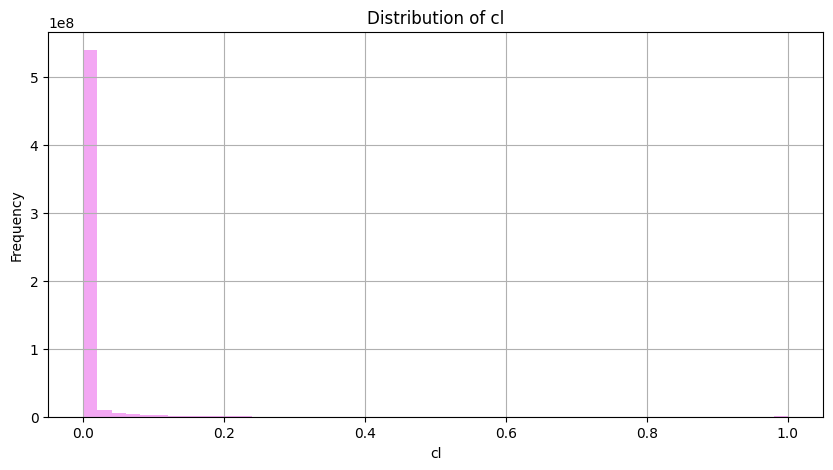

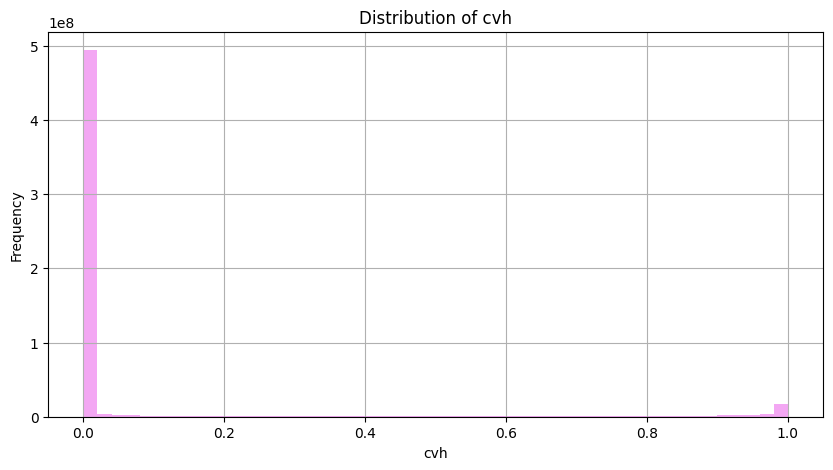

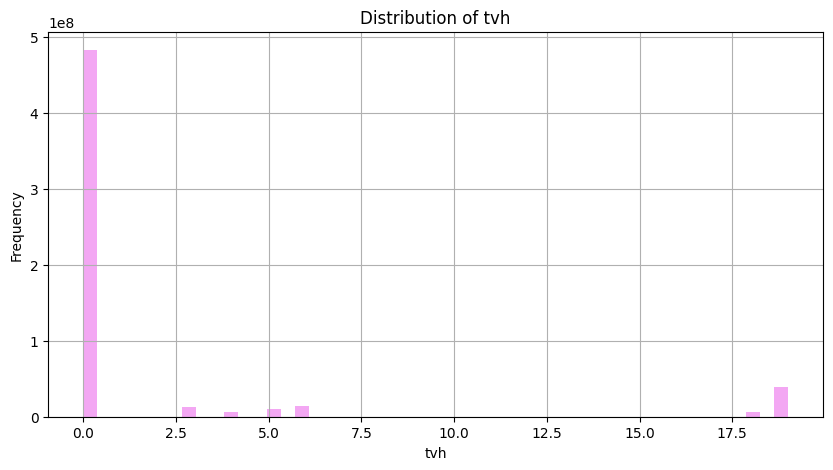

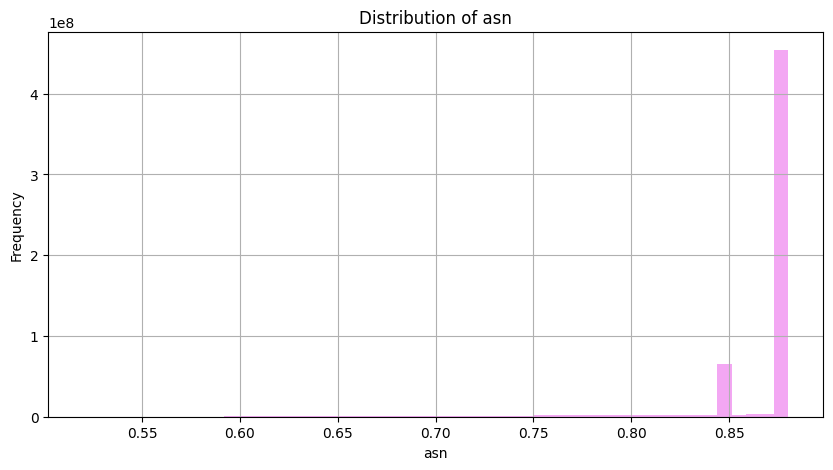

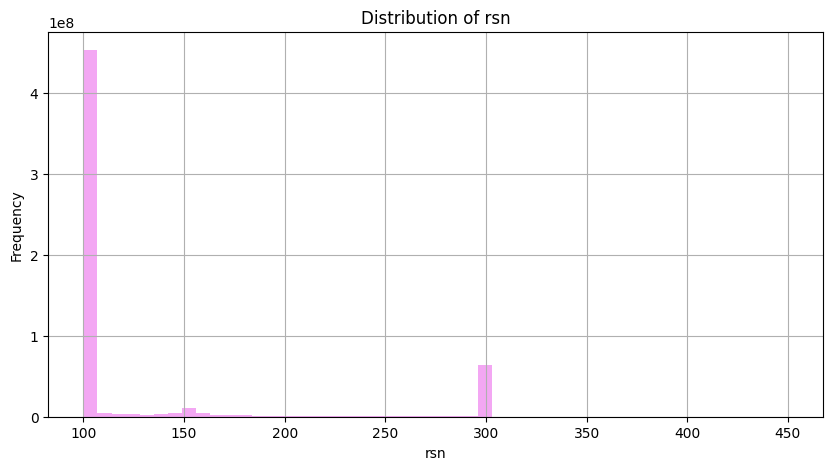

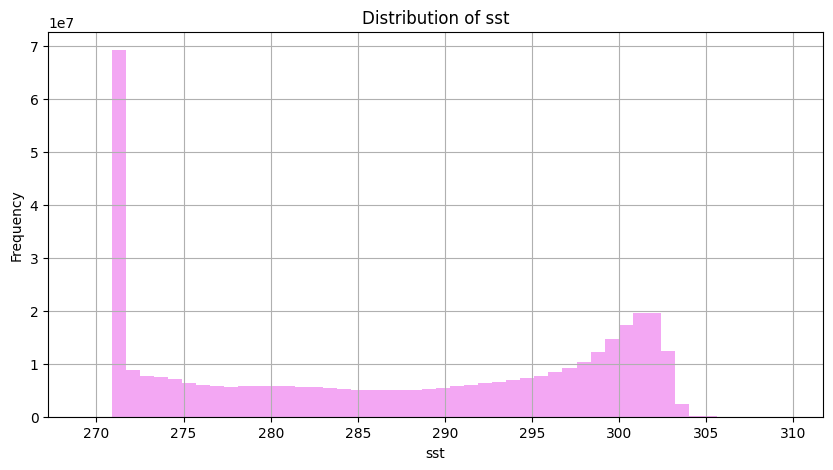

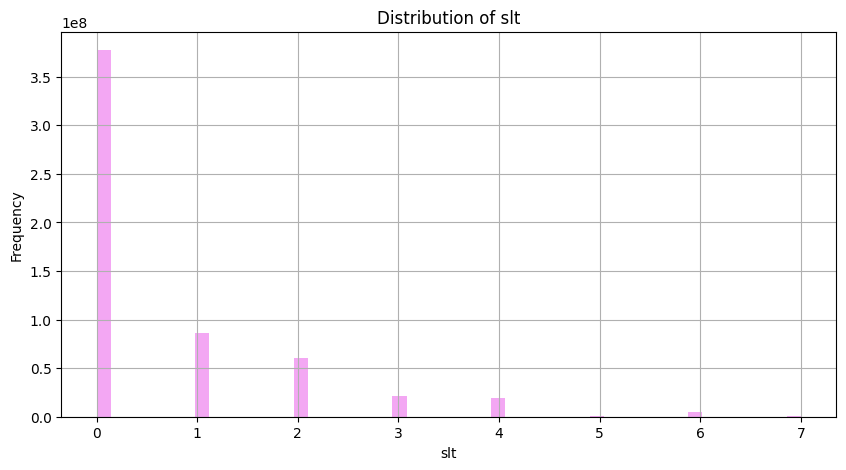

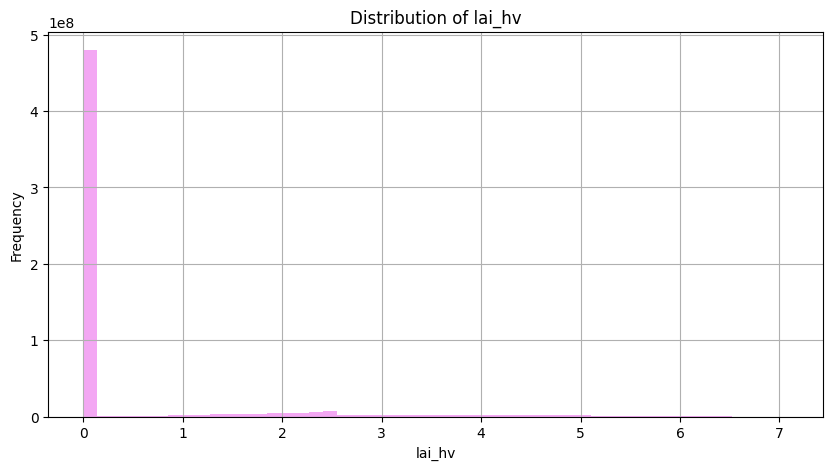

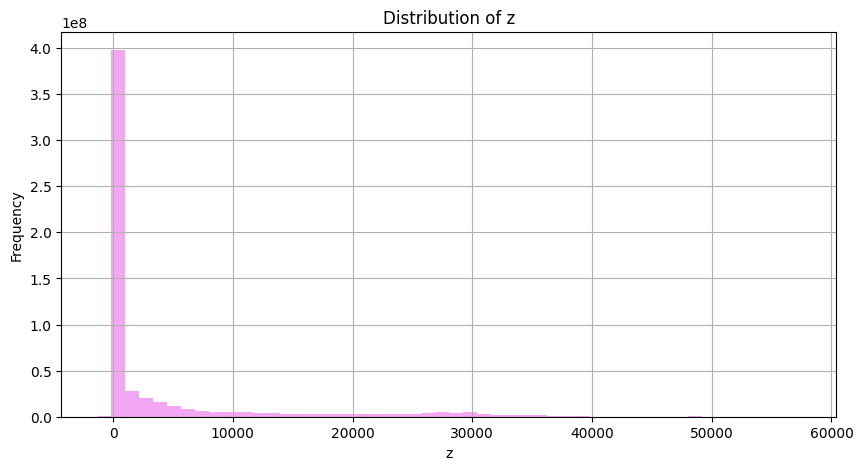

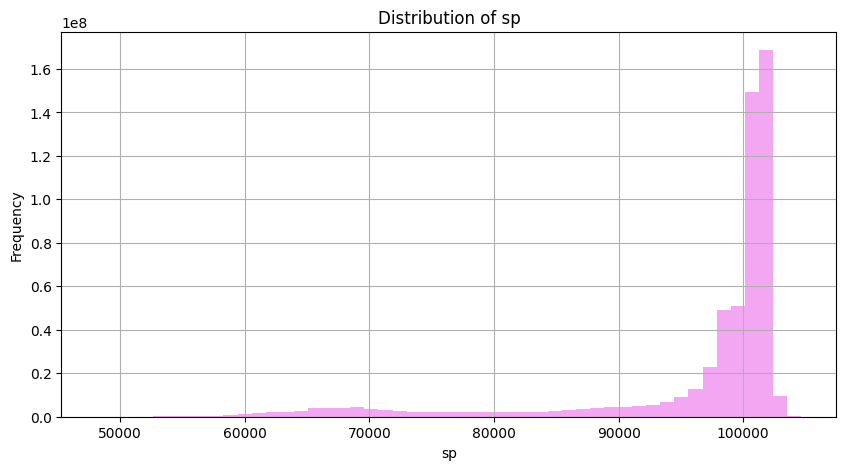

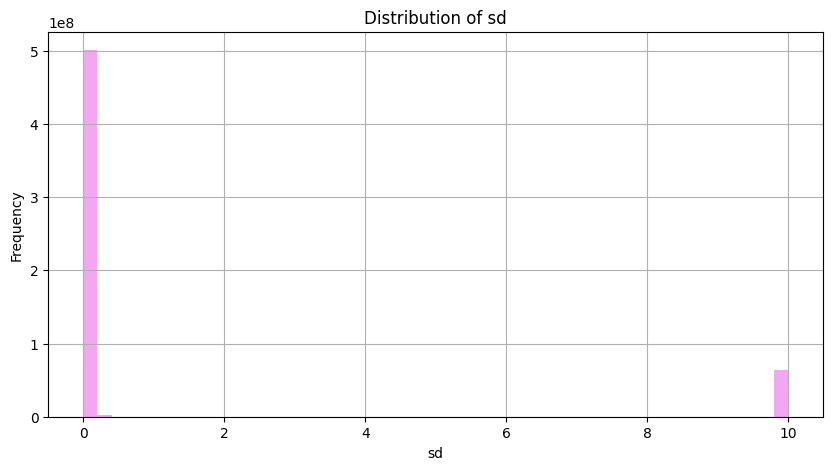

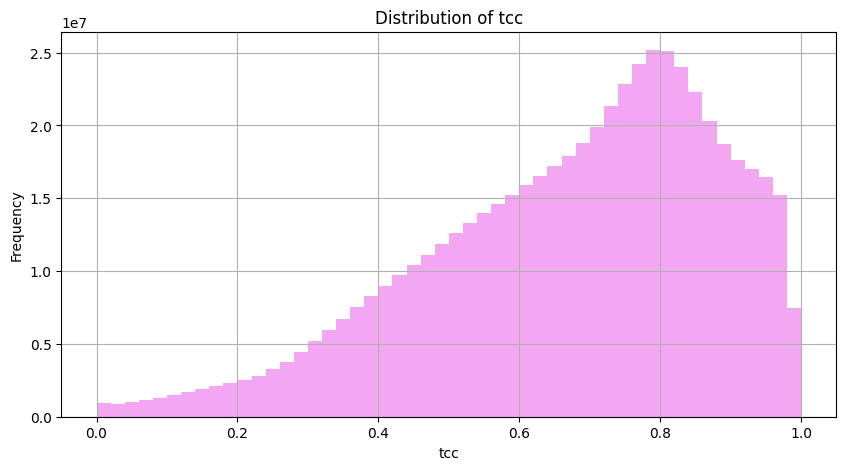

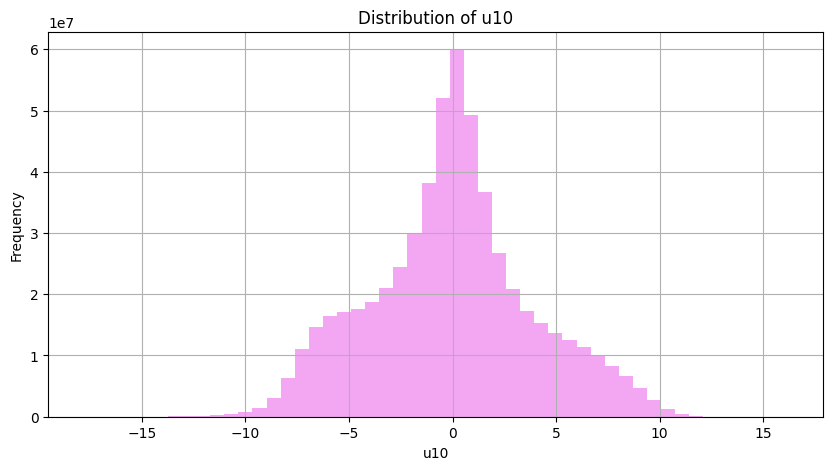

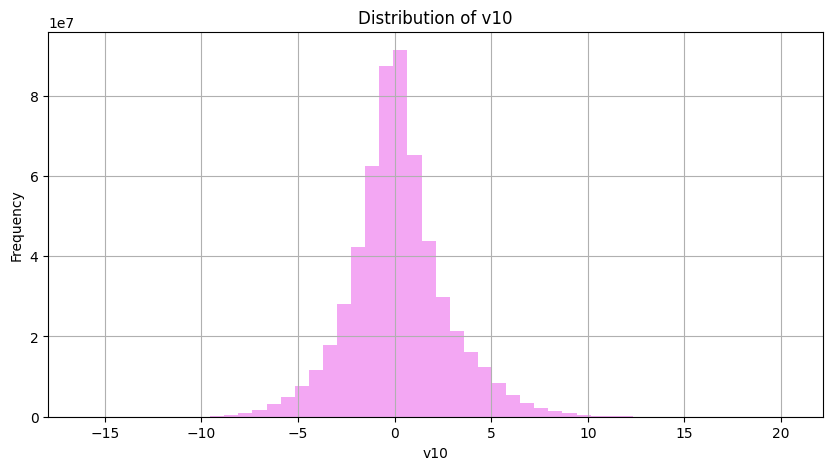

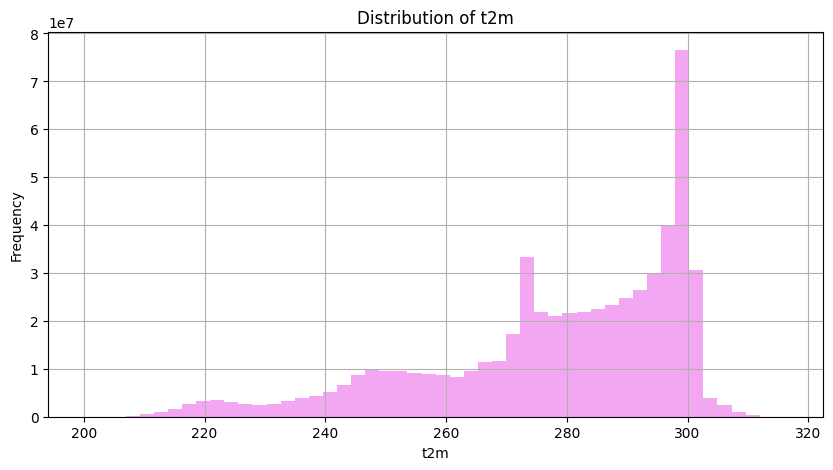

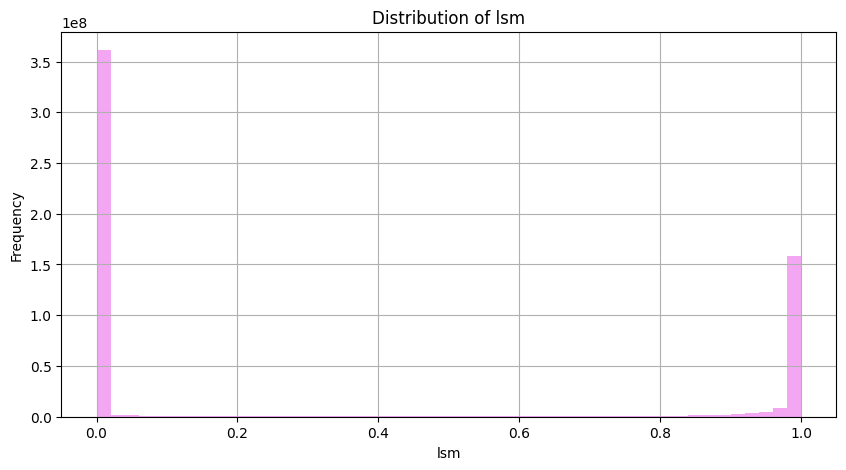

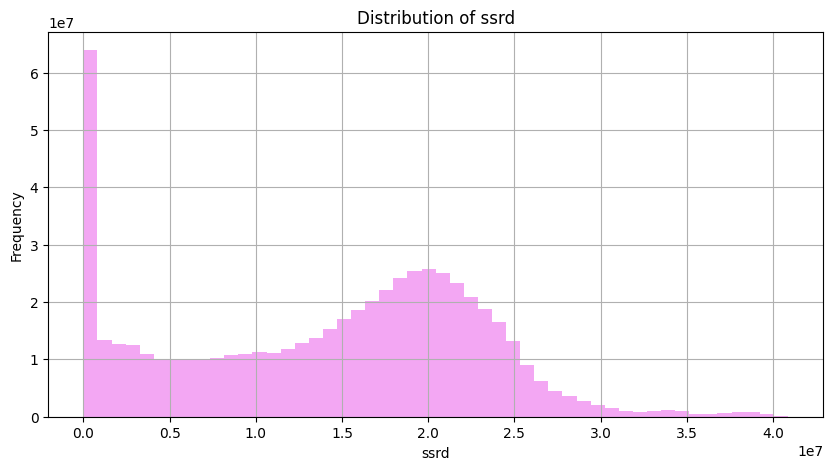

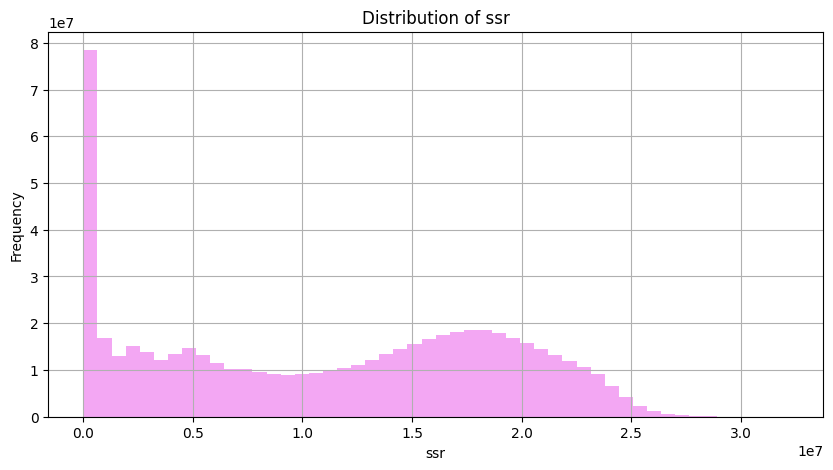

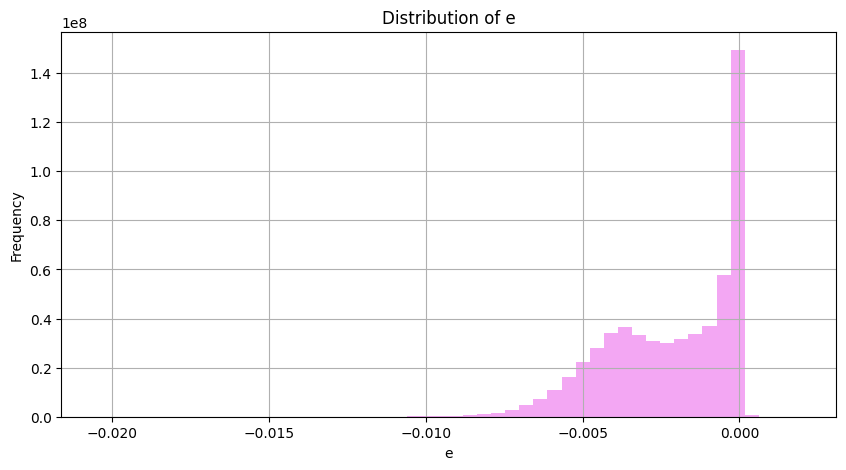

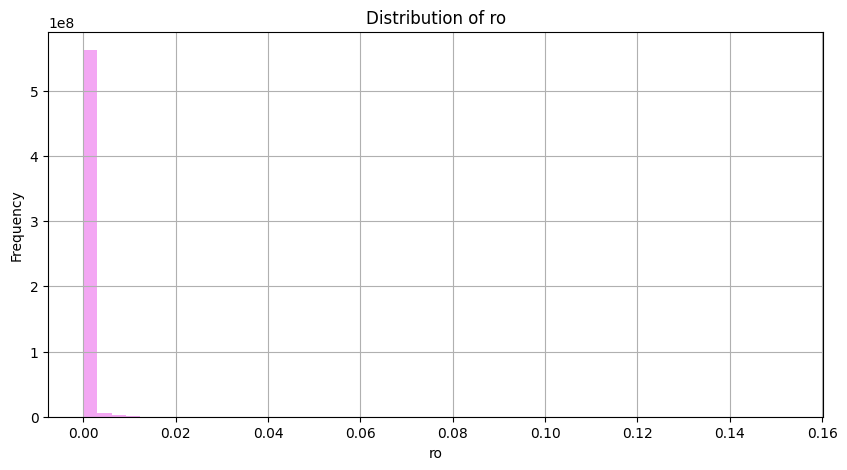

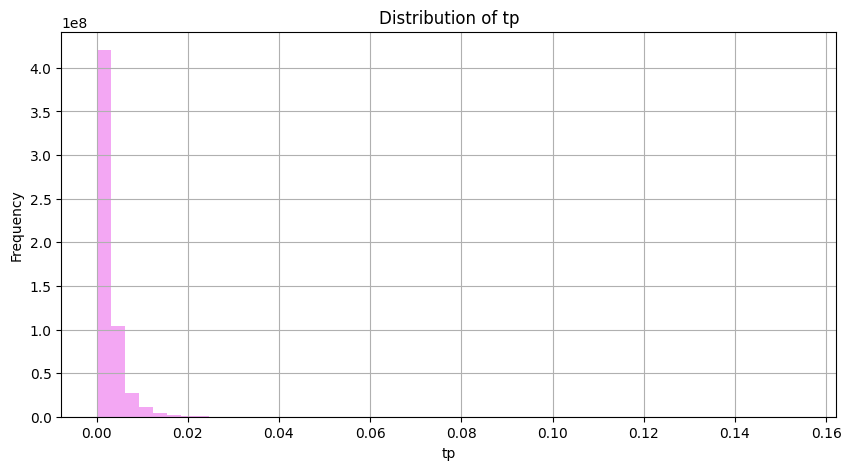

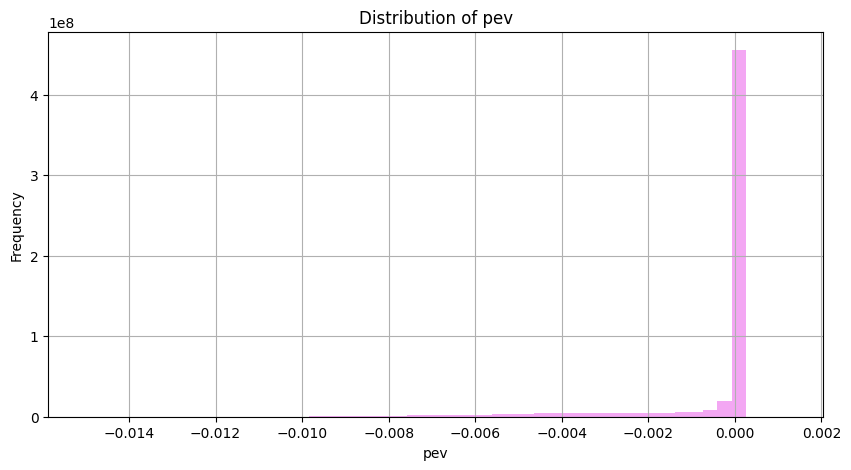

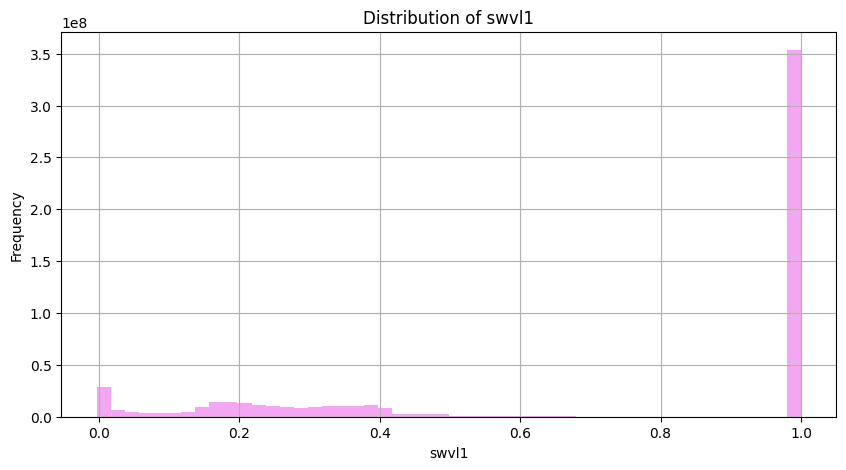

In [37]:
import xarray as xr
import matplotlib.pyplot as plt

def plot_variable_distributions(ds: xr.Dataset) -> None:
    """
    Plot the distribution of each variable in the xarray Dataset.
    
    Args:
        ds (xr.Dataset): The xarray dataset containing variables to visualize.
    """
    # Iterate over each variable in the dataset
    for var in ds.data_vars:
        data = ds[var].values.flatten()  # Flatten the data for distribution plot
        
        # Remove NaN values to avoid plotting issues
        data = data[~np.isnan(data)]
        
        plt.figure(figsize=(10, 5))
        plt.hist(data, bins=50, alpha=0.7, color='violet')
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()

# Usage
plot_variable_distributions(ds)

## Descriptive statistics

### Summmary statistics

In [23]:
ds

<xarray.Dataset> Size: 51GB
Dimensions:    (date: 561, latitude: 721, longitude: 1440)
Coordinates:
    number     int64 8B ...
  * date       (date) datetime64[ns] 4kB 1978-01-01 1978-02-01 ... 2024-09-01
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    expver     (date) <U4 9kB ...
Data variables: (12/22)
    u10        (date, latitude, longitude) float32 2GB -0.118 -0.118 ... 4.475
    v10        (date, latitude, longitude) float32 2GB -0.03694 ... 0.2595
    t2m        (date, latitude, longitude) float32 2GB 242.7 242.7 ... 222.4
    sst        (date, latitude, longitude) float32 2GB 271.5 271.5 ... 0.0 0.0
    sp         (date, latitude, longitude) float32 2GB 1.015e+05 ... 6.782e+04
    tp         (date, latitude, longitude) float32 2GB 0.0001583 ... 0.0001621
    ...         ...
    slt        (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 1.0 1.0
    cvh        (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    lai_hv     (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    tvh        (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 0.0 0.0
    z          (date, latitude, longitude) float32 2GB 0.3228 ... 2.772e+04
    lsm        (date, latitude, longitude) float32 2GB 0.0 0.0 0.0 ... 1.0 1.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-01T13:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [24]:
import xarray as xr
import pandas as pd

def generate_summary_statistics(ds: xr.Dataset) -> pd.DataFrame:
    """
    Generates summary statistics for each variable in an xarray.Dataset.

    Args:
        ds (xr.Dataset): The input dataset containing multiple variables.

    Returns:
        pd.DataFrame: A DataFrame with summary statistics for each variable, 
                      including mean, median, min, max, std, and NaN count.
    
    Example:
        summary_df = generate_summary_statistics(ds)
    """
    # Initialize an empty dictionary to store summary statistics
    stats = {
        "Variable": [],
        "Mean": [],
        "Median": [],
        "Min": [],
        "Max": [],
        "Std": [],
        "NaN Count": []
    }
    
    # Calculate statistics for each variable in the dataset
    for var_name, var_data in ds.data_vars.items():
        # Flatten the data to calculate statistics
        flat_data = var_data.values.flatten()
        
        # Append statistics to the dictionary
        stats["Variable"].append(var_name)
        stats["Mean"].append(float(var_data.mean().values))
        stats["Median"].append(float(np.nanmedian(flat_data)))
        stats["Min"].append(float(var_data.min().values))
        stats["Max"].append(float(var_data.max().values))
        stats["Std"].append(float(var_data.std().values))
        stats["NaN Count"].append(int(np.isnan(flat_data).sum()))
    
    # Convert the dictionary to a DataFrame for readability
    summary_df = pd.DataFrame(stats)
    
    return summary_df


In [25]:
# summary_df = generate_summary_statistics(ds)

In [26]:
# summary_df

# Correlations

In [36]:
import xarray as xr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_variable_correlation_heatmap(ds: xr.Dataset) -> None:
    """
    Generates a heatmap of correlations between variables in an xarray.Dataset.

    Args:
        ds (xr.Dataset): The input dataset containing multiple variables.
    
    Example:
        plot_variable_correlation_heatmap(ds)
    """
    # Aggregate data by taking the mean over spatial dimensions for each variable
    data_dict = {}
    for var_name, var_data in ds.data_vars.items():
        # Compute the mean across latitude and longitude to get a 1D time series
        time_series = var_data.mean(dim=["latitude", "longitude"], skipna=True)
        data_dict[var_name] = time_series.values

    # Convert to DataFrame for correlation calculation
    df = pd.DataFrame(data_dict, index=ds.date.values)
    
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Plot heatmap of the correlation matrix with enhanced readability
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        center=0,
        square=True,
        cbar_kws={"shrink": 0.8},
        linewidths=0.5,
        annot_kws={"size": 8}
    )
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Correlation Heatmap of Dataset Variables", fontsize=14)
    plt.show()


/usr/local/Caskroom/miniconda/base/envs/kedro-environment/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning:

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior



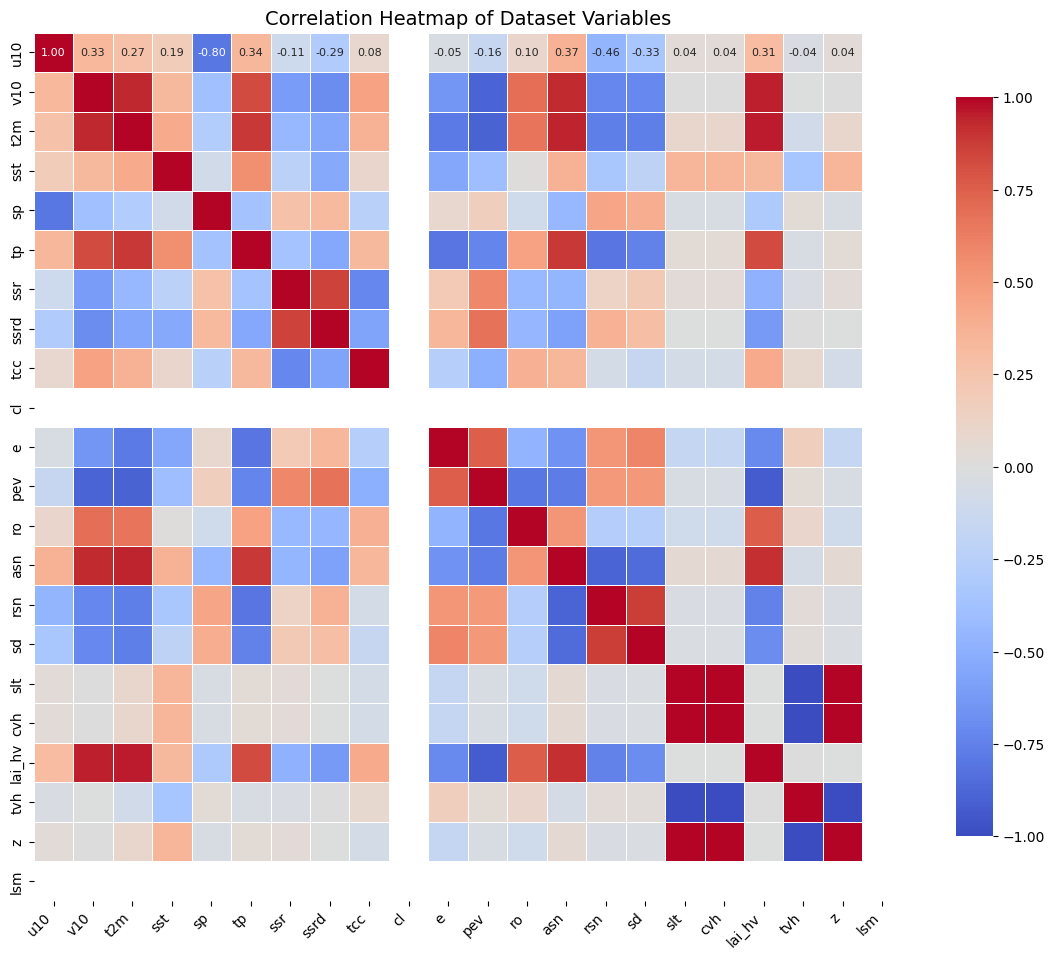

In [37]:
plot_variable_correlation_heatmap(ds)